In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:
# Load dataset
fake_df = pd.read_csv("archive2/Fake.csv")
true_df = pd.read_csv("archive2/True.csv")

fake_df["label"] = 0
true_df["label"] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

In [5]:
# Basic text preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["text"] = df["text"].apply(clean_text)

In [6]:
# Tokenization
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

def tokenize(text):
    return text.split()

tokenized_texts = df["text"].apply(tokenize)

vocab = build_vocab_from_iterator(tokenized_texts, specials=["<pad>", "<unk>"], max_tokens=10000)
vocab.set_default_index(vocab["<unk>"])

C:\Users\azizd\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\azizd\anaconda3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [7]:
# Encode sequences
encoded_texts = [torch.tensor(vocab(tokens)) for tokens in tokenized_texts]
max_len = 500
padded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab["<pad>"])
padded_texts = padded_texts[:, :max_len]  # trim if longer

labels = torch.tensor(df["label"].values)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_texts, labels, test_size=0.2, random_state=42)

In [9]:
# Create PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [10]:
# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        x = self.dropout(hidden)
        return torch.sigmoid(self.fc(x)).squeeze()
model = BiLSTM(vocab_size=len(vocab), embed_dim=128, hidden_dim=64).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# Training loop
epochs = 5
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [04:23<00:00,  1.07it/s]


Epoch 1/5, Loss: 0.0894


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [03:41<00:00,  1.27it/s]


Epoch 2/5, Loss: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [04:13<00:00,  1.11it/s]


Epoch 3/5, Loss: 0.0085


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [04:24<00:00,  1.06it/s]


Epoch 4/5, Loss: 0.0056


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [04:21<00:00,  1.07it/s]

Epoch 5/5, Loss: 0.0040


In [16]:
# Evaluation
model.eval()
y_preds = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs.cpu() > 0.5).int()
        y_preds.extend(preds.numpy())
        y_true.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(y_test, y_preds))
print("\nClassification Report:\n", classification_report(y_test, y_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_preds))


Accuracy: 0.9983
Precision: 0.9998
Recall: 0.9967
F1 Score: 0.9982


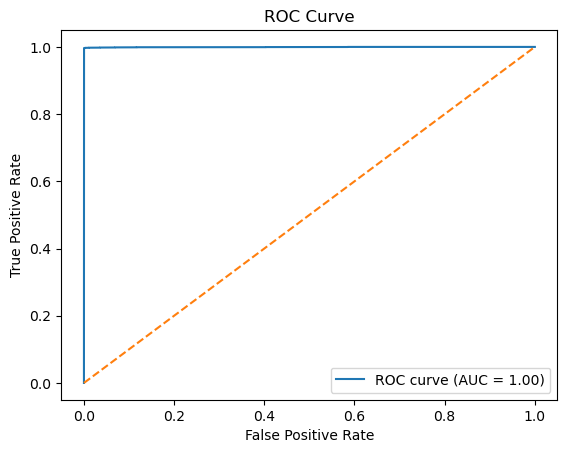

In [13]:
# ROC curve
y_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        probs = model(X_batch)
        y_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate ")
plt.title("ROC Curve")
plt.legend()
plt.show()